# CNN little project (fruits)

https://www.kaggle.com/moltean/fruits/

In [8]:
# packages

In [9]:
import tensorflow as tf
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

import pandas as pd


In [10]:
import glob
import numpy as np
import os
import shutil

# import cv2

np.random.seed(42)

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

In [12]:
print(tf.__version__)
# print(tensorflow.keras.__version__)
print(tf.test.gpu_device_name())
# print(tf.test.is_gpu_available())

2.1.0
/device:GPU:0


In [13]:
import time

# Outline
- First, let's took a brief look at the data. Specifically, we need to figure out the data size (i.e. training dataset and validation dataset), image size, the quality of the data (i.e. high resolution, blur, etc.). Also we need to have feeling the variance of the images, which might affect training behavior (i.e. underfitting, overfitting). 
- Then decide the target, i.e. vegetable vs. fruits, super-classes (i.e. apple, pear, cherry), or the sub-classes of fruits (i.e. Apple Braeburn, Apple Crimson Snow, etc.) Based on the target, we can do some data preprocessing, i.e. train-test split, and labeling. In this small project, I will adopt the label as the original dataset, i.e. Apple Braeburn, Apple Crimson Snow, etc. So the classification target has 131 labels.

### pipeline
- Let's start with a proportion of the whole dataset (trail data) to build the pipeline and use a small number of epoch to train the trail data against several CNN structures.
- From the trail data training, we can determine CNN structure, and use it to train and validate against the whole dataset.
- (maybe I will perform tranfer learning to compare the performances)

# Load of the actual images

In [7]:
# X_train = [] # training fruit images
# y_train = [] # training fruit labels 

# X_test = [] # test fruit images
# y_test = [] # test fruit labels 

IMG_DIM = (100, 100)
# IMG_DIM = (32, 32)

In [8]:
train_imgs = [] # training fruit images
train_labels = [] # training fruit labels 

for dir_path in glob.glob(".\\fruits-360\\sup-class\\train_test\\*"):
# for dir_path in glob.glob(".\\fruits-360\\sup-class\\Training\\*"):
    img_label = dir_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, IMG_DIM)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img_to_array(load_img(img_path, target_size=IMG_DIM))
        train_imgs.append(img)
        train_labels.append(img_label)
#         X_train.append(img)
#         y_train.append(img_label)
        
train_imgs=np.array(train_imgs)
train_labels=np.array(train_labels)

print('Train dataset shape:', train_imgs.shape)

Train dataset shape: (7814, 100, 100, 3)


In [9]:
train_labels

array(['Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', ...,
       'Avocado ripe', 'Avocado ripe', 'Avocado ripe'], dtype='<U19')

In [10]:
validation_imgs = [] # test fruit images
validation_labels = [] # test fruit labels 

for dir_path in glob.glob(".\\fruits-360\\sup-class\\test_test\\*"):
# for dir_path in glob.glob(".\\fruits-360\\sup-class\\Test\\*"):
    img_label = dir_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
        img = img_to_array(load_img(img_path, target_size=IMG_DIM))
        validation_imgs.append(img)
        validation_labels.append(img_label)
        
validation_imgs=np.array(validation_imgs)
validation_labels=np.array(validation_labels)

print('Test dataset shape:', validation_imgs.shape)
# Test dataset shape: (4574, 150, 150, 3)'

Test dataset shape: (2607, 100, 100, 3)


In [11]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255



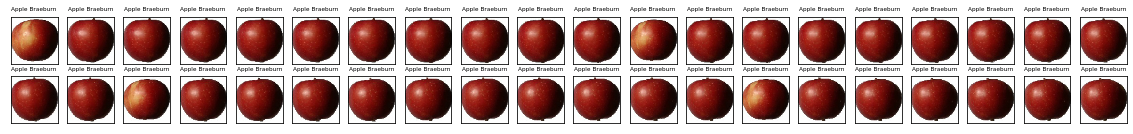

In [12]:
# ckeck validity
# i=0
# print(train_imgs[i].shape)
# print(train_labels[i])
# array_to_img(train_imgs[i])

fig = plt.figure(figsize=(20,2))
for i in range (40):
    ax = fig.add_subplot(2,20,i+1, xticks=[], yticks=[])
    ax.imshow(train_imgs_scaled[i])
    ax.set_title(train_labels[i], fontsize='xx-small')
    


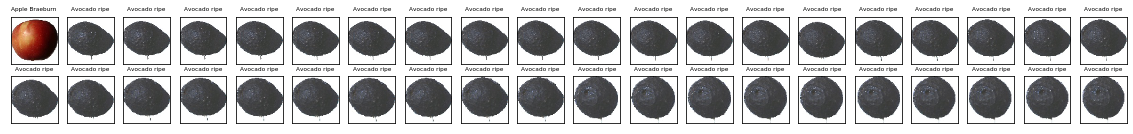

In [13]:
fig = plt.figure(figsize=(20,2))
for i in range (40):
    ax = fig.add_subplot(2,20,i+1, xticks=[], yticks=[])
    ax.imshow(validation_imgs_scaled[-i])
    ax.set_title(validation_labels[-i], fontsize='xx-small')

In [14]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[10:15], train_labels_enc[100:105])

['Apple Braeburn' 'Apple Braeburn' 'Apple Braeburn' 'Apple Braeburn'
 'Apple Braeburn'] [0 0 0 0 0]


In [15]:
print(train_labels_enc)
print(validation_labels_enc)

[ 0  0  0 ... 15 15 15]
[ 0  0  0 ... 15 15 15]


### some comment
From observation, the images in training and test dataset are very similar to each other. Actually, according to the dataset description on Kaggle, the images are taken from one object of each target class from differnt angles, respectively. 
Note that since the data sample is relatively small(131 classes, around 70k samples in total, around 2000 samples in each sub-class, ), the images are taken from a non-complex background, the training result is inclined to overfitting. But since this project is just for illustration purpose, also the training and test data come from similar photographing situation, we can still apply CNN on the data.

# CNN Model

### before we start
we designing a neural network, i.e. CNN, we need to decide
- how many layers we would like to go, and how complex each layer is, i.e. how many fiters for Conv2D
- based on the task, determine the loss function and output layer, i.e. this is a classification problem (loss function: cross_entropy vs. MSE), we are using non-one-hot-encoding (i.e. sparse_cross_entropy vs. cross_entroy), output = label numbers, activation='softmax', etc.
- optimizer, i.e. Adam, RMSProp, etc. (while this doesn't crtically affect the result)
- batch size, epoch numbers, and learning rate. (This can be spotted and tuned during epoch training and validation.
- last but not least, shuffle=True in model.fit(). This is set to True by default. It can at best help prevent overfitting. 

The following part, we will train 5 versions of CNN, namely,
- V1: with 3 ConvNet (each one followed by a MaxPooling2D layer)
- V2: based on V1, adjust MaxPooling pool_size parameter (better capture the overall features)
- V3: based on V1, increase filter numbers at each ConvNet layer (more complex)
- V4: trail with 4 ConvNet (too deep)
- V5: trail with 1 ConvNet (too shallow)

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [17]:
# v1 (default maxpooling2D setting and conv2D setting)

In [18]:
input_shape = train_imgs[0].shape
input_shape

(100, 100, 3)

In [19]:
model = Sequential()
nf1=20; nf2=40; nf3=20; 
# pad='same'
# input_shape = IMG_DIM
    
# First conv layer
model.add(Conv2D(filters=nf1, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
# Second conv layer
model.add(Conv2D(filters=nf2, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
# Third conv layer 
model.add(Conv2D(filters=nf3, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# use GlobalAveragePooling2D to flatten, no need to specify flatten input          
model.add(GlobalAveragePooling2D())
# model.add(Flatten())
    
# Output with 131 neurons ( train_labels_enc[-1]+1 classes )
model.add(Dense(train_labels_enc[-1]+1, activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 20)        560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 40)        7240      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 20)        7220      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 20)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 20)                0

In [20]:
epochs = 10
batch_size = 30
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                
                    verbose=1)

Train on 7814 samples, validate on 2607 samples
Epoch 1/10
7814/7814 [==============================] - 16s 2ms/sample - loss: 1.5752 - accuracy: 0.4741 - val_loss: 0.8367 - val_accuracy: 0.7307
Epoch 2/10
7814/7814 [==============================] - 5s 636us/sample - loss: 0.4167 - accuracy: 0.8846 - val_loss: 0.3412 - val_accuracy: 0.8941
Epoch 3/10
7814/7814 [==============================] - 5s 631us/sample - loss: 0.1771 - accuracy: 0.9525 - val_loss: 0.2477 - val_accuracy: 0.9202
Epoch 4/10
7814/7814 [==============================] - 5s 629us/sample - loss: 0.1198 - accuracy: 0.9631 - val_loss: 0.1773 - val_accuracy: 0.9425
Epoch 5/10
7814/7814 [==============================] - 5s 625us/sample - loss: 0.1009 - accuracy: 0.9660 - val_loss: 0.2362 - val_accuracy: 0.9179
Epoch 6/10
7814/7814 [==============================] - 5s 631us/sample - loss: 0.0777 - accuracy: 0.9692 - val_loss: 0.1547 - val_accuracy: 0.9267
Epoch 7/10
7814/7814 [==============================] - 5s 631us/

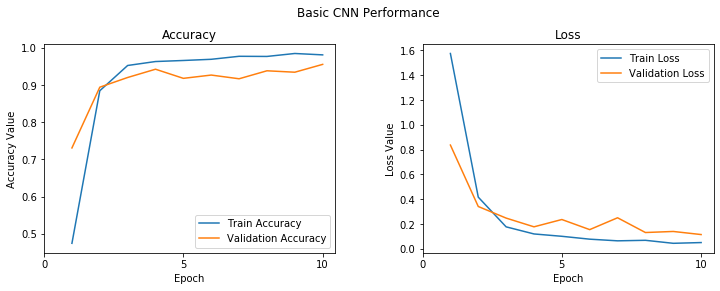

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
try:
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
except:
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
# perforamnce evaluation

In [22]:
from sklearn.metrics import classification_report
pred_class = model.predict_classes(x=validation_imgs_scaled)
print(classification_report(y_true=validation_labels_enc, y_pred=pred_class))

In [ ]:
# outside image to predict

In [37]:
unseen_imgs = [] # training fruit images
unseen_labels = [] # training fruit labels 

for dir_path in glob.glob(".\\fruits-360\\sup-class\\unseen\\*"):
# for dir_path in glob.glob(".\\fruits-360\\sup-class\\Training\\*"):
#     img_label = dir_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
        img_label = img_path.split("\\")[-1].split(".")[0]
        img = img_to_array(load_img(img_path, target_size=IMG_DIM))
        unseen_imgs.append(img)
        unseen_labels.append(img_label)
        
unseen_imgs=np.array(unseen_imgs)
unseen_labels=np.array(unseen_labels)

unseen_imgs_scaled = unseen_imgs.astype('float32')
unseen_imgs_scaled /= 255

print('unseen dataset shape:', unseen_imgs.shape)
print(unseen_labels)

unseen dataset shape: (4, 100, 100, 3)
['gala' 'genger_gold' 'mcintosh' 'paula_red']


In [38]:
pred_class_unseen = model.predict_classes(x=unseen_imgs_scaled)

pred_class_name = le.inverse_transform(pred_class_unseen)
pred_class_name

array(['Apple Red 1', 'Apple Golden 1', 'Apple Red 1', 'Apple Red 1'],
      dtype='<U19')

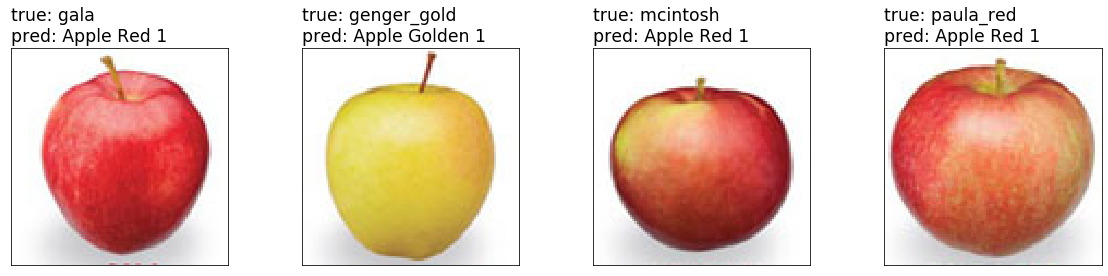

In [53]:
fig = plt.figure(figsize=(20,4))
for i in range (4):
    ax = fig.add_subplot(1,4,i+1, xticks=[], yticks=[])
    ax.imshow(unseen_imgs_scaled[i])
    ax.set_title('true: '+ unseen_labels[i]+
                 '\n'+
                 'pred: '+ pred_class_name[i], fontsize='xx-large', loc='left')

In [107]:
# v2 (change maxpooling2D setting)

In [108]:
model = Sequential()
nf1=20; nf2=40; nf3=20; 
pad='same'
    
# First conv layer
model.add(Conv2D(filters=nf1,padding=pad, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(4, 4),strides=(2,2),padding=pad))
    
# Second conv layer
model.add(Conv2D(filters=nf2,padding=pad, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(4, 4),strides=(2,2),padding=pad))
    
# Third conv layer 
model.add(Conv2D(filters=nf3,padding=pad, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(4, 4),strides=(2,2),padding=pad))
 
model.add(GlobalAveragePooling2D())
# model.add(Flatten())
    
# Output with 131 neurons ( 131 classes )
# Output with 131 neurons ( train_labels_enc[-1]+1 classes )
model.add(Dense(train_labels_enc[-1]+1, activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 100, 100, 20)      560       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 50, 50, 40)        7240      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 25, 25, 40)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 25, 25, 20)        7220      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 13, 13, 20)        0         
_________________________________________________________________
global_average_pooling2d_14  (None, 20)              

In [109]:
epochs = 10
batch_size = 30
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                
                    verbose=1)

Train on 7814 samples, validate on 2607 samples
Epoch 1/10
7814/7814 [==============================] - 7s 885us/sample - loss: 1.5973 - accuracy: 0.4953 - val_loss: 0.4826 - val_accuracy: 0.8884
Epoch 2/10
7814/7814 [==============================] - 5s 672us/sample - loss: 0.2640 - accuracy: 0.9341 - val_loss: 0.2586 - val_accuracy: 0.8949
Epoch 3/10
7814/7814 [==============================] - 5s 653us/sample - loss: 0.1124 - accuracy: 0.9708 - val_loss: 0.1009 - val_accuracy: 0.9751
Epoch 4/10
7814/7814 [==============================] - 5s 659us/sample - loss: 0.0795 - accuracy: 0.9768 - val_loss: 0.0488 - val_accuracy: 0.9977
Epoch 5/10
7814/7814 [==============================] - 5s 655us/sample - loss: 0.0521 - accuracy: 0.9848 - val_loss: 0.0650 - val_accuracy: 0.9728
Epoch 6/10
7814/7814 [==============================] - 5s 656us/sample - loss: 0.0439 - accuracy: 0.9855 - val_loss: 0.0503 - val_accuracy: 0.9877
Epoch 7/10
7814/7814 [==============================] - 5s 654us

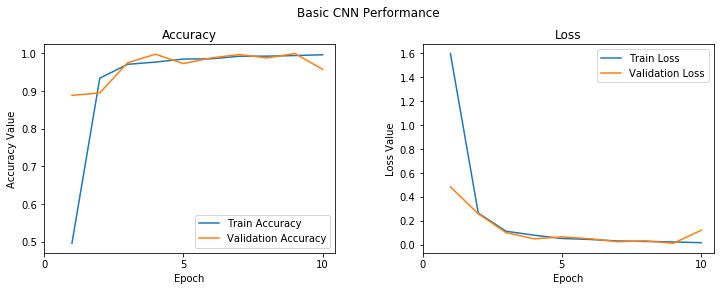

In [110]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
try:
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
except:
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [111]:
# v3 (change filter number in conv2D)

In [112]:
model = Sequential()
nf1=16; nf2=64; nf3=128; 
# pad='same'
    
# First conv layer
model.add(Conv2D(filters=nf1, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
# Second conv layer
model.add(Conv2D(filters=nf2, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
# Third conv layer 
model.add(Conv2D(filters=nf3, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# use GlobalAveragePooling2D to flatten, no need to specify flatten input          
model.add(GlobalAveragePooling2D())
# model.add(Flatten())
    
# Output with 131 neurons ( train_labels_enc[-1]+1 classes )
model.add(Dense(train_labels_enc[-1]+1, activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 47, 47, 64)        9280      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
global_average_pooling2d_15  (None, 128)             

In [113]:
epochs = 10
batch_size = 30
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                
                    verbose=1)

Train on 7814 samples, validate on 2607 samples
Epoch 1/10
7814/7814 [==============================] - 6s 826us/sample - loss: 1.1379 - accuracy: 0.6236 - val_loss: 0.5504 - val_accuracy: 0.7975
Epoch 2/10
7814/7814 [==============================] - 5s 649us/sample - loss: 0.2573 - accuracy: 0.9166 - val_loss: 0.1903 - val_accuracy: 0.9306
Epoch 3/10
7814/7814 [==============================] - 5s 636us/sample - loss: 0.1143 - accuracy: 0.9638 - val_loss: 0.1558 - val_accuracy: 0.9513
Epoch 4/10
7814/7814 [==============================] - 5s 635us/sample - loss: 0.0920 - accuracy: 0.9698 - val_loss: 0.1841 - val_accuracy: 0.9248
Epoch 5/10
7814/7814 [==============================] - 5s 646us/sample - loss: 0.0588 - accuracy: 0.9798 - val_loss: 0.1084 - val_accuracy: 0.9440
Epoch 6/10
7814/7814 [==============================] - 5s 639us/sample - loss: 0.0557 - accuracy: 0.9813 - val_loss: 0.1349 - val_accuracy: 0.9248
Epoch 7/10
7814/7814 [==============================] - 5s 646us

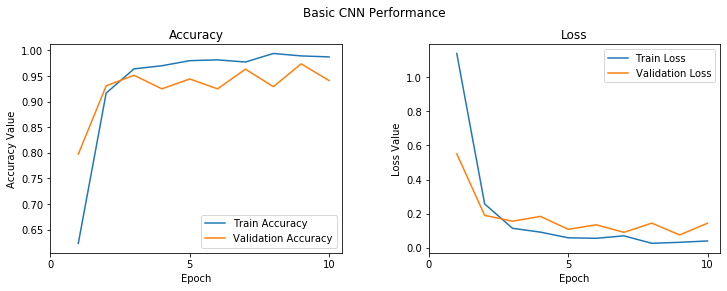

In [114]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
try:
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
except:
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [115]:
# v4 too deep CNN

In [116]:
model = Sequential()
nf1=16; nf2=64; nf3=128; 
# pad='same'
    
# First conv layer
model.add(Conv2D(filters=nf1, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
# Second conv layer
model.add(Conv2D(filters=nf2, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
# Third conv layer 
model.add(Conv2D(filters=nf3, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=nf3, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# use GlobalAveragePooling2D to flatten, no need to specify flatten input          
model.add(GlobalAveragePooling2D())
# model.add(Flatten())
    
# Output with 131 neurons ( train_labels_enc[-1]+1 classes )
model.add(Dense(train_labels_enc[-1]+1, activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 47, 47, 64)        9280      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 8, 128)       

In [117]:
epochs = 10
batch_size = 30
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                
                    verbose=1)

Train on 7814 samples, validate on 2607 samples
Epoch 1/10
7814/7814 [==============================] - 7s 878us/sample - loss: 0.7532 - accuracy: 0.7385 - val_loss: 0.1281 - val_accuracy: 0.9651
Epoch 2/10
7814/7814 [==============================] - 5s 676us/sample - loss: 0.1094 - accuracy: 0.9601 - val_loss: 0.2643 - val_accuracy: 0.8991
Epoch 3/10
7814/7814 [==============================] - 5s 670us/sample - loss: 0.1307 - accuracy: 0.9612 - val_loss: 0.2123 - val_accuracy: 0.9175
Epoch 4/10
7814/7814 [==============================] - 5s 682us/sample - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.2675 - val_accuracy: 0.9329
Epoch 5/10
7814/7814 [==============================] - 5s 683us/sample - loss: 0.0139 - accuracy: 0.9955 - val_loss: 0.1752 - val_accuracy: 0.9421
Epoch 6/10
7814/7814 [==============================] - 5s 689us/sample - loss: 0.0396 - accuracy: 0.9894 - val_loss: 0.5177 - val_accuracy: 0.9125
Epoch 7/10
7814/7814 [==============================] - 5s 673us

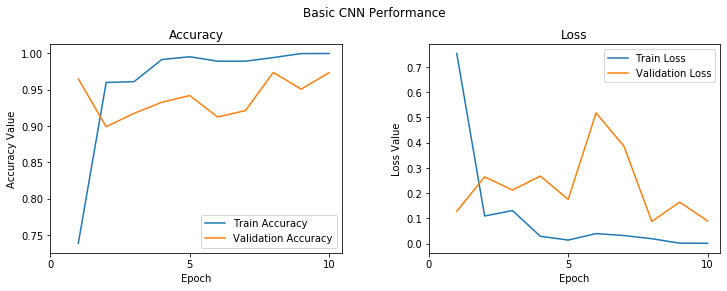

In [118]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
try:
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
except:
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [119]:
# v5 too shallow

In [120]:
model = Sequential()
nf1=16; nf2=64; nf3=128; 
# pad='same'
    
# First conv layer
model.add(Conv2D(filters=nf1, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# use GlobalAveragePooling2D to flatten, no need to specify flatten input          
model.add(GlobalAveragePooling2D())
# model.add(Flatten())
    
# Output with 131 neurons ( train_labels_enc[-1]+1 classes )
model.add(Dense(train_labels_enc[-1]+1, activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
global_average_pooling2d_17  (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
Total params: 720
Trainable params: 720
Non-trainable params: 0
_________________________________________________________________


In [121]:
epochs = 20
batch_size = 30
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                
                    verbose=1)

Train on 7814 samples, validate on 2607 samples
Epoch 1/20
7814/7814 [==============================] - 5s 649us/sample - loss: 2.7374 - accuracy: 0.0994 - val_loss: 2.6652 - val_accuracy: 0.2221
Epoch 2/20
7814/7814 [==============================] - 4s 501us/sample - loss: 2.5371 - accuracy: 0.2652 - val_loss: 2.3779 - val_accuracy: 0.3510
Epoch 3/20
7814/7814 [==============================] - 4s 500us/sample - loss: 2.1829 - accuracy: 0.3579 - val_loss: 2.0093 - val_accuracy: 0.4285
Epoch 4/20
7814/7814 [==============================] - 4s 500us/sample - loss: 1.8400 - accuracy: 0.5054 - val_loss: 1.7265 - val_accuracy: 0.4956
Epoch 5/20
7814/7814 [==============================] - 4s 501us/sample - loss: 1.5812 - accuracy: 0.6067 - val_loss: 1.5020 - val_accuracy: 0.6609
Epoch 6/20
7814/7814 [==============================] - 4s 500us/sample - loss: 1.3824 - accuracy: 0.6996 - val_loss: 1.3417 - val_accuracy: 0.6628
Epoch 7/20
7814/7814 [==============================] - 4s 499us

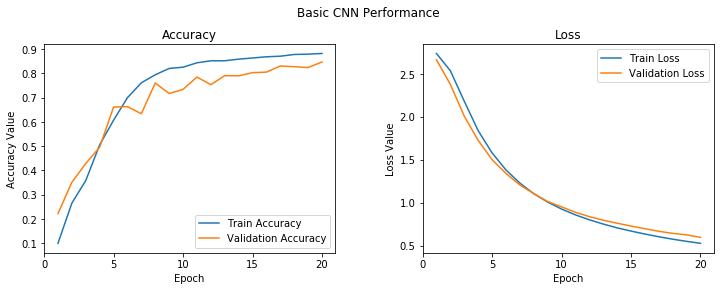

In [122]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
try:
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
except:
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [123]:
# some comment

Recall we have trained the following CNN
- V1: with 3 ConvNet (each one followed by a MaxPooling2D layer)
- V2: based on V1, adjust MaxPooling pool_size parameter (better capture the overall features)
- V3: based on V1, increase filter numbers at each ConvNet layer (more complex)
- V4: trail with 4 ConvNet (too deep)
- V5: trail with 1 ConvNet (too shallow)

Among the CNN structures, V2 has the best performance, V5 has the worst performance.
- V1 is a good starting point. The CNN structure has proper number of layers and associated ConvNet filter numbers.
- V2 improved V1's performance by increasing pool_size, which can better capture the overall feature. (though it would not always guarantee better performance).
- Following V2, V3 has second to the best performance. V3 increased filter numbers, which helped to capture more image details. This is helpful if we need more details to classify the objects, i.e. Apple Braeburn, Apple Crimson Snow. Apple were more complex, which is not the case here. Note, too many filters might also introduce noice to the CNN and cause unstable performance, which is the case in a more realistic dataset.
- V4's performance is too bad (even argubaly better than V1). The issue of V4 is the structure is heavy-weighted, which is definetly not worth the trouble with such performance. Also, it seems like V4 has some overfitting issue (though I am not sure it is the case)
- V5 has the worst perforamance. The problem is the structure is too shallow for the CNN to learn. We can definetely see that V5 learn very slow, not to mention validation perforamnce never catch up with the performance on training data. (note that I am using twice as much epoch on V5 as other versions.)

# training on the whole dataset using V2

In [14]:
IMG_DIM = (100, 100)
# IMG_DIM = (32, 32)

train_imgs = [] # training fruit images
train_labels = [] # training fruit labels 

# for dir_path in glob.glob(".\\fruits-360\\sup-class\\train_test\\*"):
for dir_path in glob.glob(".\\fruits-360\\sup-class\\Training\\*"):
    img_label = dir_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
#         img = cv2.imread(img_path)
#         img = cv2.resize(img, IMG_DIM)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img_to_array(load_img(img_path, target_size=IMG_DIM))
        train_imgs.append(img)
        train_labels.append(img_label)
#         X_train.append(img)
#         y_train.append(img_label)
        
train_imgs=np.array(train_imgs)
train_labels=np.array(train_labels)

print('Train dataset shape:', train_imgs.shape)

# train_labels



Train dataset shape: (67692, 100, 100, 3)


In [15]:
validation_imgs = [] # test fruit images
validation_labels = [] # test fruit labels 

# for dir_path in glob.glob(".\\fruits-360\\sup-class\\test_test\\*"):
for dir_path in glob.glob(".\\fruits-360\\sup-class\\Test\\*"):
    img_label = dir_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
        img = img_to_array(load_img(img_path, target_size=IMG_DIM))
        validation_imgs.append(img)
        validation_labels.append(img_label)
        
validation_imgs=np.array(validation_imgs)
validation_labels=np.array(validation_labels)

print('Test dataset shape:', validation_imgs.shape)
# Test dataset shape: (4574, 150, 150, 3)'

train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255



Test dataset shape: (22688, 100, 100, 3)


In [17]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[10:15], train_labels_enc[100:105])

['Apple Braeburn' 'Apple Braeburn' 'Apple Braeburn' 'Apple Braeburn'
 'Apple Braeburn'] [0 0 0 0 0]


In [128]:
input_shape = train_imgs[0].shape
input_shape

(100, 100, 3)

In [129]:
# v2 (change maxpooling2D setting)

In [130]:
model = Sequential()
nf1=20; nf2=40; nf3=20; 
pad='same'
    
# First conv layer
model.add(Conv2D(filters=nf1,padding=pad, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(4, 4),strides=(2,2),padding=pad))
    
# Second conv layer
model.add(Conv2D(filters=nf2,padding=pad, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(4, 4),strides=(2,2),padding=pad))
    
# Third conv layer 
model.add(Conv2D(filters=nf3,padding=pad, kernel_size=(3,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(4, 4),strides=(2,2),padding=pad))
 
model.add(GlobalAveragePooling2D())
# model.add(Flatten())
    
# Output with 131 neurons ( 131 classes )
# Output with 131 neurons ( train_labels_enc[-1]+1 classes )
model.add(Dense(train_labels_enc[-1]+1, activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 100, 100, 20)      560       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 50, 50, 40)        7240      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 25, 25, 40)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 25, 25, 20)        7220      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 13, 13, 20)        0         
_________________________________________________________________
global_average_pooling2d_18  (None, 20)              

In [131]:
epochs = 20
batch_size = 30
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                
                    verbose=1)

Train on 67692 samples, validate on 22688 samples
Epoch 1/20
67692/67692 [==============================] - 47s 690us/sample - loss: 1.5010 - accuracy: 0.6115 - val_loss: 0.6663 - val_accuracy: 0.8087
Epoch 2/20
67692/67692 [==============================] - 44s 652us/sample - loss: 0.3004 - accuracy: 0.9078 - val_loss: 0.4259 - val_accuracy: 0.8776
Epoch 3/20
67692/67692 [==============================] - 44s 654us/sample - loss: 0.1731 - accuracy: 0.9463 - val_loss: 0.2934 - val_accuracy: 0.9197
Epoch 4/20
67692/67692 [==============================] - 44s 657us/sample - loss: 0.1208 - accuracy: 0.9609 - val_loss: 0.2676 - val_accuracy: 0.9303
Epoch 5/20
67692/67692 [==============================] - 44s 656us/sample - loss: 0.0913 - accuracy: 0.9707 - val_loss: 0.2769 - val_accuracy: 0.9296
Epoch 6/20
67692/67692 [==============================] - 44s 655us/sample - loss: 0.0719 - accuracy: 0.9775 - val_loss: 0.2334 - val_accuracy: 0.9365
Epoch 7/20
67692/67692 [====================

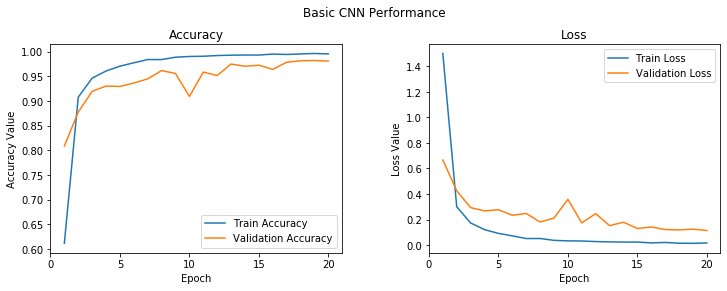

In [132]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
try:
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
except:
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### In final model, we have accuracy rate a little bit above 0.98.

In [20]:
from tensorflow.keras.models import load_model
model = load_model(".\\history\\fruits_from_scratch.h5")


In [21]:
# perforamnce evaluation

In [37]:
pred_class = model.predict_classes(x=validation_imgs_scaled)
pred_class_name = le.inverse_transform(pred_class)
pred_class_name

array(['Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', ...,
       'Watermelon', 'Watermelon', 'Watermelon'], dtype='<U19')

In [60]:
str(list((enumerate(np.unique(pred_class_name)))))

"[(0, 'Apple Braeburn'), (1, 'Apple Crimson Snow'), (2, 'Apple Golden 1'), (3, 'Apple Golden 2'), (4, 'Apple Golden 3'), (5, 'Apple Granny Smith'), (6, 'Apple Pink Lady'), (7, 'Apple Red 1'), (8, 'Apple Red 2'), (9, 'Apple Red 3'), (10, 'Apple Red Delicious'), (11, 'Apple Red Yellow 1'), (12, 'Apple Red Yellow 2'), (13, 'Apricot'), (14, 'Avocado'), (15, 'Avocado ripe'), (16, 'Banana'), (17, 'Banana Lady Finger'), (18, 'Banana Red'), (19, 'Beetroot'), (20, 'Blueberry'), (21, 'Cactus fruit'), (22, 'Cantaloupe 1'), (23, 'Cantaloupe 2'), (24, 'Carambula'), (25, 'Cauliflower'), (26, 'Cherry 1'), (27, 'Cherry 2'), (28, 'Cherry Rainier'), (29, 'Cherry Wax Black'), (30, 'Cherry Wax Red'), (31, 'Cherry Wax Yellow'), (32, 'Chestnut'), (33, 'Clementine'), (34, 'Cocos'), (35, 'Corn'), (36, 'Corn Husk'), (37, 'Cucumber Ripe'), (38, 'Cucumber Ripe 2'), (39, 'Dates'), (40, 'Eggplant'), (41, 'Fig'), (42, 'Ginger Root'), (43, 'Granadilla'), (44, 'Grape Blue'), (45, 'Grape Pink'), (46, 'Grape White'), (

In [68]:
from sklearn.metrics import classification_report

label_name_list = ['('+str(i)+ ') ' + name for i,name in enumerate(np.unique(pred_class_name))]
label_name_list

print(classification_report(y_true=validation_labels_enc, y_pred=pred_class,
                           labels=range(len(np.unique(pred_class_name))),
                            target_names=label_name_list,))
     

                          precision    recall  f1-score   support

      (0) Apple Braeburn       1.00      0.95      0.97       164
  (1) Apple Crimson Snow       0.95      1.00      0.98       148
      (2) Apple Golden 1       1.00      1.00      1.00       160
      (3) Apple Golden 2       1.00      1.00      1.00       164
      (4) Apple Golden 3       1.00      1.00      1.00       161
  (5) Apple Granny Smith       1.00      1.00      1.00       164
     (6) Apple Pink Lady       0.80      1.00      0.89       152
         (7) Apple Red 1       0.85      1.00      0.92       164
         (8) Apple Red 2       0.95      1.00      0.98       164
         (9) Apple Red 3       1.00      1.00      1.00       144
(10) Apple Red Delicious       0.93      1.00      0.97       166
 (11) Apple Red Yellow 1       1.00      1.00      1.00       164
 (12) Apple Red Yellow 2       1.00      1.00      1.00       219
            (13) Apricot       1.00      1.00      1.00       164
         

In [23]:
# outside image to predict

In [ ]:
unseen_imgs = [] # training fruit images
unseen_labels = [] # training fruit labels 

for dir_path in glob.glob(".\\fruits-360\\sup-class\\unseen\\*"):
# for dir_path in glob.glob(".\\fruits-360\\sup-class\\Training\\*"):
#     img_label = dir_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(dir_path, "*.jpg")):
        img_label = img_path.split("\\")[-1].split(".")[0]
        img = img_to_array(load_img(img_path, target_size=IMG_DIM))
        unseen_imgs.append(img)
        unseen_labels.append(img_label)
        
unseen_imgs=np.array(unseen_imgs)
unseen_labels=np.array(unseen_labels)

unseen_imgs_scaled = unseen_imgs.astype('float32')
unseen_imgs_scaled /= 255

print('unseen dataset shape:', unseen_imgs.shape)
print(unseen_labels)

In [36]:
pred_class_unseen = model.predict_classes(x=unseen_imgs_scaled)
pred_prob_unseen = model.predict_proba(x=unseen_imgs_scaled)
print(pred_prob_unseen.max(axis=1))

pred_class_name = le.inverse_transform(pred_class_unseen)
pred_class_name

[0.855813   0.75921655 0.9998914  0.988037  ]


array(['Pear Red', 'Physalis with Husk', 'Pear Red', 'Cherry Rainier'],
      dtype='<U19')

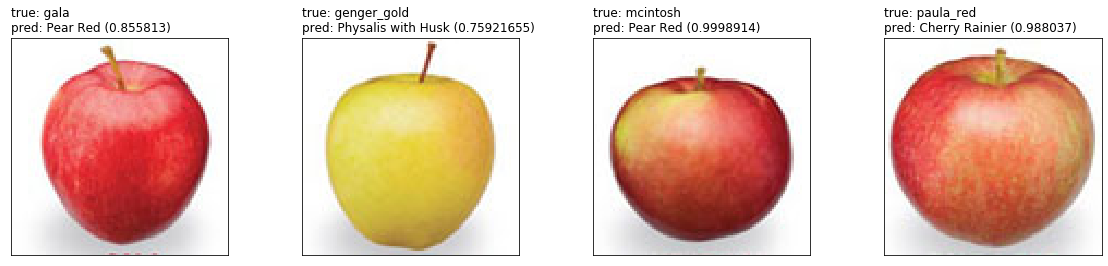

In [35]:
fig = plt.figure(figsize=(20,4))
for i in range (4):
    ax = fig.add_subplot(1,4,i+1, xticks=[], yticks=[])
    ax.imshow(unseen_imgs_scaled[i])
    ax.set_title('true: '+ unseen_labels[i]+
                 '\n'+
                 'pred: '+ pred_class_name[i]+ " (" + str(pred_prob_unseen.max(axis=1)[i]) +")", fontsize='large', loc='left')

### some comment
the result is not ideal at first galance, especially if we only care about how much the prediction and true labels are matched. i.e. the genger_gold apple doesn't look like physalis to me at all. (considering the probability is 0.75)
However if you take a closer look, the paula red apple looks like a reainier cherry as well, especially neglecting the size (such infomation is not included in the picture). 

In general, the CNN classifier did a fair job to learn different type of fruits. But we should not over-interprete the meaning of the labels (just like what we have shown in the unseen apple classifier).

This is a reminder of the issue I have mentioned before. Since this dataset is not taken from real-world enviorment, it might not be very representative. Also the dataset has very similar training and test data, it might not reveal the overfitting problem. Another issue is the label might not be generative enough, this might bring in a large overlapping area, i.e. Pear Red and apple red. Last but not least, even though image data include a lot of information but it is not omniponent. i.e. perpective tranformation (from different angles), size of the object (or deep information).